## Simulate and Plot Data

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import particle_filter as pf
from proj_data import proj_data
from lotvol_model import LotVolModel

key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)


x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

y_meas, x_state = pf.meas_sim(lotvol_model, n_obs, x_init, theta, subkey)


Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

Text(0.5, 1.0, 'Observations and Latent')

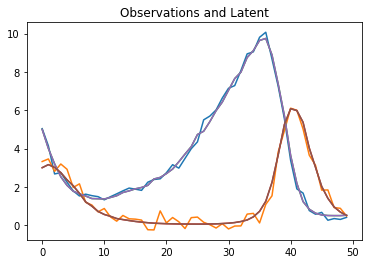

In [2]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent")

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

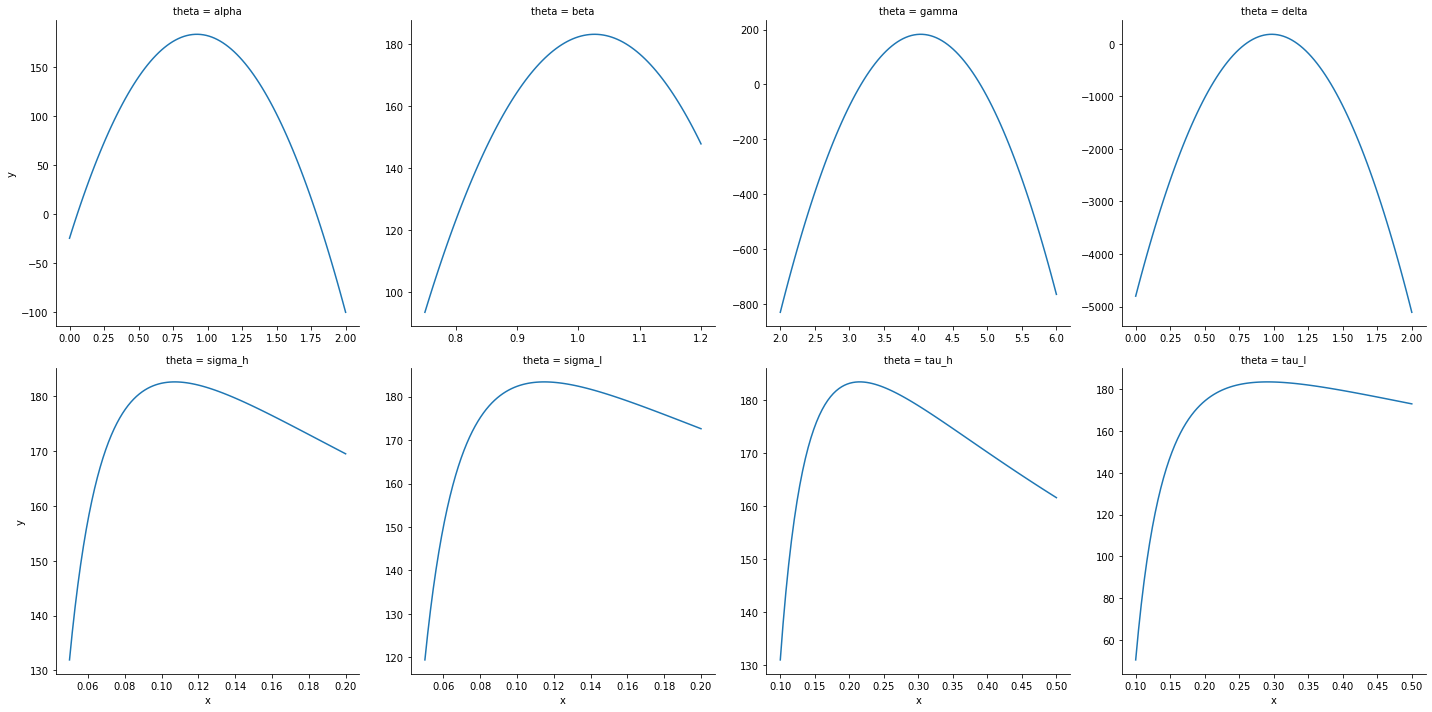

In [3]:
theta_lims = np.array([[0., 2.], [.75, 1.2], [2.0, 6.0], [0., 2.],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot


@jax.jit
def lotvol_loglik(theta):
    return pf.joint_loglik(model=lotvol_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(lotvol_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

## Parameter Estimation with Particle Filter

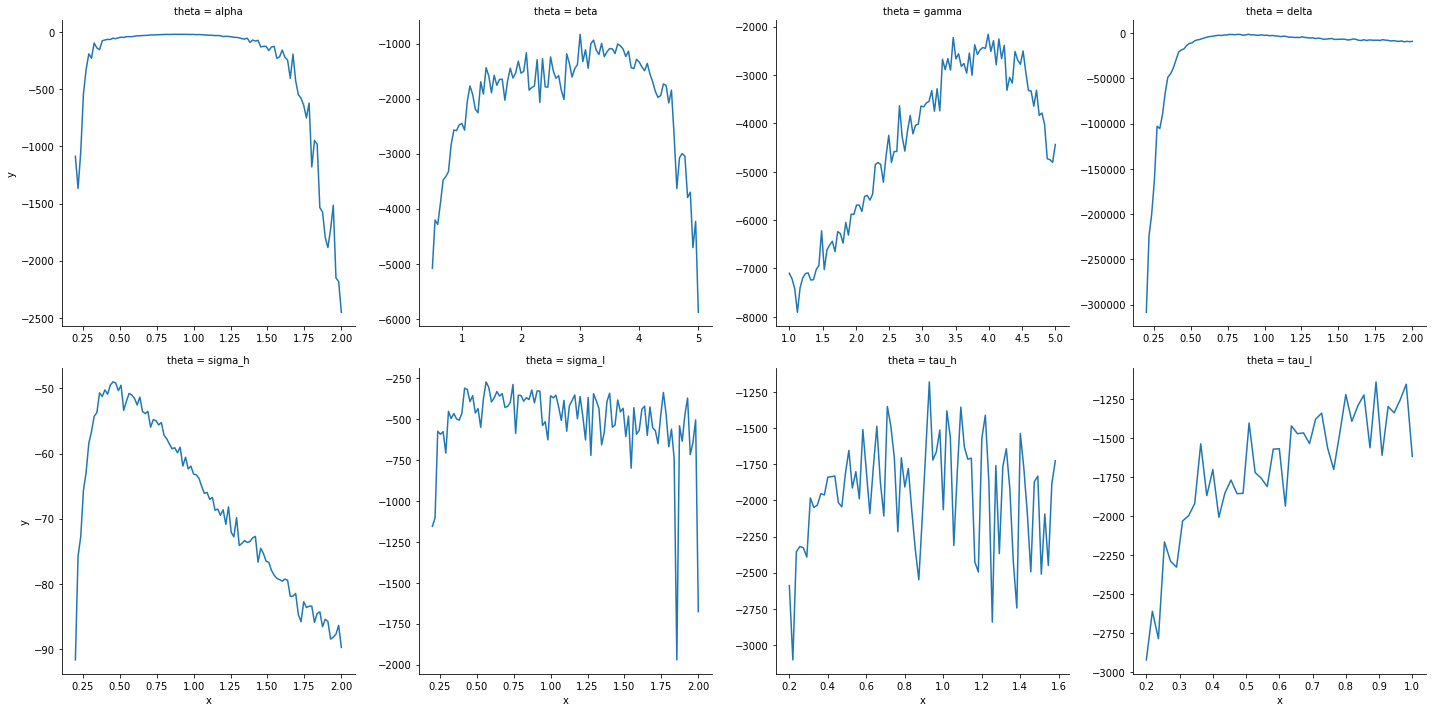

In [13]:
theta_lims = np.array([[0.2, 2.], [0.5, 5.], [1.0, 5.0], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

In [ ]:
from particle_filter import stoch_opt, get_sum_lweights

In [ ]:
stoch_opt(lotvol_model, jnp.array([1.,1.,4., 1., 0.01, 0.01, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.0000000001, iterations=2000, n_particles=1000,
         mask=np.array([0,1,0,0,0,0,0,0]))

## Scratch

In [ ]:
n_particles = 10

pf_out = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)

In [ ]:
i_obs = 1
print(pf_out["X_particles"][i_obs])
print(y_meas[i_obs])

In [9]:
theta

array([2.  , 1.  , 4.  , 1.  , 0.1 , 0.1 , 0.25, 0.25])

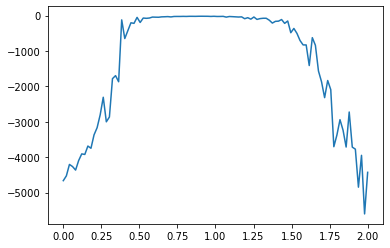

In [4]:
@jax.jit
def lotvol_pflik(theta, key):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])

n_particles = 100

i_theta = 0 # which index of theta to update
theta_min = theta_lims[i_theta][0]
theta_max = theta_lims[i_theta][1]
#theta_min = 3.0
#theta_max = 5.0
theta_seq = np.linspace(theta_min, theta_max, num=n_pts)
ll_seq = np.zeros(theta_seq.shape)
for i in range(n_pts):
    key, subkey = random.split(key)
    theta_tmp = theta
    theta_tmp[i_theta] = theta_seq[i]
    ll_seq[i] = lotvol_pflik(theta_tmp, subkey)
    #theta_tmp = theta_tmp.at[0].set(alpha_seq[i])
    #ll_seq = ll_seq.at[i].set(lotvol_pflik(theta_tmp, subkey))

plt.plot(theta_seq, ll_seq)